# Technical Analysis Indicators: Customisable Relative Strength Indices (and Moving Averages & Volatilities)

In this article, we build a data-frame to output an instrument's Daily (i) Close Prices, (ii) ln (logarithme naturel / natural logarithm) Return, (iii) Close Price's 10, 30 and 60 Day Moving Averages, (iv) Close Price's ln Return 10, 30 and 60 Day Moving Average, (v) Annualised Standard Deviation (i.e.: volatility) of the 10, 30 and 60 Day Rolling Window (Natural Log) Returns (based on CLOSE prices), and (vi) [Relative Strength Index (RSI)](https://www.investopedia.com/terms/r/rsi.asp).

When it comes to the RSI data, a great article to read about its implementation can be found [here](https://developers.refinitiv.com/article/create-technical-analysis-triggers-and-signals-using-eikon-data-api) (thank you [Umer](https://www.linkedin.com/in/umer-nalla/) and [Jason](https://www.linkedin.com/in/jason-ramchandani-8459599/)!). You may want to read into the [installation of the TA-Lib library used to compute RSI data here](https://github.com/mrjbq7/ta-lib). You may also want to read into how the way TA-lib calculates RSI; as per its [GitHub documentation](https://github.com/mrjbq7/ta-lib/blob/master/docs/func_groups/momentum_indicators.md), it uses a [Wilder Smoothing method to compute Moving Averages](http://www.tadoc.org/indicator/RSI.htm). Others may use different such methods (e.g.: Exponential Moving Average or Simple Moving Average). More information on [Refinitiv Workspace's Chart App](cpurl://apps.cp./Apps/NewFinancialChart/?st=RIC) RSI can be found [here](https://emea1.apps.cp.thomsonreuters.com/Apps/HelpCharts/#cs) and [here](https://www.tradingview.com/support/solutions/43000502338-relative-strength-index-rsi/). Previous RSI Python functions do not provide great amounts of customisation; in this article, we will create a Python function that does just that.

## Relative Strength Index
The [Relative Strength Index (RSI)](https://www.investopedia.com/terms/r/rsi.asp) is a value between 0 and 100 calculated for any one asset based on its historical price; it indicates an asset as oversold if bellow a certain threshold - *idest* (*i.e.*): it's underpriced - and overbought if above a certain threshold - *i.e.*: it's overpriced. RSI at time $t$ is calculated $RSI_{w, m, t}$ where $w$ is the window asked for (e.g.: 14) and where $m$ is either (i) $SMA$ (Simple Moving Average) or $Cutler$, (ii) $EMA$ (Exponential Moving Average), or (iii) $Wilder$ or $MEMA$ (Modified Exponential Moving Average):

(i) with $SMA$ (Simple Moving Average) or $Cutler$ such that $m_1=\{SMA, Cutler\}$:
$$ RSI_{w, m_1, t} = 
    \begin{Bmatrix}
        100 & \text{if } \sum_{i=1}^w{|min(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)|} = 0 \\
        100 - \frac{100}{ 1 +\frac{
	        \sum_{i=1}^w{max(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)}}
	        {\sum_{i=1}^w{|min(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)|}}
	    } & \text{otherwise}
    \end{Bmatrix}
$$

(ii) & (iii) with $EMA$, or $Wilder$ / $MEMA$ such that $m_2=\{EMA, Wilder, MEMA\}$:

$$
RSI_{w, m_2, 1} = RSI_{w, m_1, 1}
$$

and

$$ RSI_{w, m_2, \tau} = 
	100 - \frac{100}{
	    \left[ 1 + 
	        \frac{
		        a_m * \left(
		        	max(P_{\tau} - P_{\tau-i} \text{ }, \text{ } 0) \right)
		        + (1 - a_m) * \left(
		        	\sum_{i=1}^w{max(P_{\tau-i+1} - P_{\tau-i} \text{ }, \text{ } 0)} \right)}{
		    	a_m * \left(
		        	|min(P_{\tau} - P_{\tau-1} \text{ }, \text{ } 0)| \right)
		        + (1 - a_m) * \left(
		        	\sum_{i=1}^w{|min(P_{\tau-i+1} - P_{\tau-i} \text{ }, \text{ } 0)|} \right)}
		\right]}
$$

where $\tau > 1$, and

$$ a_m = 
    \begin{Bmatrix}
        a_{MEMA} = a_{Wilder} = & \frac{1}{w} & \text{if } m \text{ is } MEMA \text{ or } Wilder \\
        a_{EMA} = & \frac{2}{w + 1} & \text{if } m = EMA
    \end{Bmatrix}
$$

And it is computed as such:

In [1]:
start_date, end_date, bdpy = '2020-01-01', '2021-08-01', 360  # ' bdpy ' stands for 'business days per year'
maws = [10, 30, 60]  # ' maws ' stands for 'moving average windows'
rsiw = 14
rsi_method = "Wilder"  # "SMA", "EMA", "Wilder"
ric_list = ['KO.N', 'VOD.L']

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta  # '2.8.1'
import numpy  # '1.18.2'
import statistics
import pandas  # '1.2.4'
pandas.set_option('display.max_columns', None) # This allows us to see all the collumns of our dataframe

In [3]:
import eikon as ek
# The key is placed in a text file so that it may be used in this code without showing it itself:
eikon_key = open("eikon.txt", "r")
ek.set_app_key(str(eikon_key.read()))
# It is best to close the files we opened in order to make sure that we don't stop any other services/programs from accessing them if they need to:
eikon_key.close()

In [4]:
df1, err = ek.get_data(
    instruments=ric_list,
    fields=['TR.PriceClose.date', 'TR.PriceOpen', 'TR.PriceClose', 'TR.VOlume'],  # could also have TR.RSISimple30D & TR.RSISimple14D
    parameters={'SDate': start_date, 'EDate': end_date})

In [5]:
# Step 1: Create a list of days ranging throughout our period.
# The reason we look at every day is because some securities might trade on Sunday (e.g.: in middle-east)
delta = datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')
days = [datetime.strptime(start_date, '%Y-%m-%d') + relativedelta(days=i)
        for i in range(delta.days + 1)]

# Step 2: Create a pandas data-frame to populate with a loop
df2 = pandas.DataFrame(index=days)

# Step 3: Create a loop to populate our 'df' dataframe
# for m, i in enumerate(ric_list):
for i in ric_list:

    # get Close Prices: (You may use any way to collect such data, here we are recycling previous data)
    _df = pandas.DataFrame(
        data=[float(j) for j in df1[df1["Instrument"] == i]["Price Close"]],
        columns=[f"{i} Close"],
        index=[datetime.strptime(df1[df1["Instrument"] == i]["Date"][j],
                                 '%Y-%m-%dT%H:%M:%SZ')
               for j in list(df1[df1["Instrument"] == i]["Date"].index)])

    # get ln (logarithme naturel) return from Close Prices:
    _df[f"{i}'s ln Return"] = numpy.log(
        _df[f"{i} Close"] / _df[i + " Close"].shift(1))

    # get 1st difference in Close Prices:
    dCP = list((_df[f"{i} Close"] - _df[f"{i} Close"].shift(1)))
#     dCP.insert(0, numpy.nan)
    # list.reverse(dCP)
    _df[f"{i}'s 1d Close"] = dCP

    for j in maws:
        # get Close Price's 10, 30 and 60 Day Moving Averages
        _df[f"{i}'s Close {str(j)}D MA"] = _df[f"{i} Close"].dropna().rolling(j).mean()

        # get Close Price's ln Return 10, 30 and 60 Day Moving Average
        _df[f"{i}'s ln Return' {str(j)}D MA"] = _df[f"{i}'s ln Return"].dropna().rolling(j).mean()
#         # You may also want to look into TA-lib's Simple Moving Average function:
#         _df[i + "'s ln Return' " + str(j) + " Day Moving Average"] = ta.SMA(_df[i + " Close"], j)

        # get Annualised Standard Deviation (i.e.: volatility) of the 10, 30 and 60 Day Rolling Window (Natural Log) Returns (based on CLOSE prices)
        _df[f"{i}'s Ann. S.D. of {str(j)}D Roll. of ln Returns"] = _df[f"{i}'s ln Return"].dropna().rolling(j).std()*(bdpy**0.5)


    # RSI: Simple Moving Average
    if rsi_method == "SMA" or rsi_method == "Cutler":
        RSIw = []
        for k in range(len(dCP) - rsiw):
            up_moves, down_moves = [], []
            for j in range(k, k + rsiw):
                up_moves.append(max(dCP[j + 1], 0))  # ' + 1 ' because we're looking at 1st difference data, the 1st element of which is always nan.
                down_moves.append(abs(min(dCP[j + 1], 0)))   # ' + 1 ' because we're looking at 1st difference data, the 1st element of which is always nan.
            AvgU = statistics.mean(up_moves)
            AvgD = statistics.mean(down_moves)
            if AvgD == 0:
                RSIw.append(100)
            else:
                RSw = AvgU/AvgD
                RSIw.append(100-(100/(1+RSw)))
    # RSI: Exponential Moving Average
    if rsi_method == "EMA" or rsi_method == "MEMA" or rsi_method == "Wilder":
        if rsi_method == "MEMA" or rsi_method == "Wilder":
            a = 1 / rsiw
        elif rsi_method == "EMA":
            a = 2 / (rsiw + 1)
        RSIw, up_moves, down_moves = [], [], []
        for k in dCP[1:]:  # ' [1:] ' because we're looking at 1st difference data, the 1st element of which is always nan.
            up_moves.append(max(k, 0))
            down_moves.append(abs(min(k, 0)))
        AvgU = [statistics.mean(up_moves[0:rsiw])]
        AvgD = [statistics.mean(down_moves[0:rsiw])]
        if AvgD[0] == 0:
            RSIw.append(100)
        else:
            RSw = AvgU[0] / AvgD[0]
            RSIw.append(100 - (100 / (1 + RSw)))
        for k in range(rsiw, len(up_moves)):
            AvgU.append(a * up_moves[k] + (1 - a) * AvgU[k - rsiw])
            AvgD.append(a * down_moves[k] + (1 - a) * AvgD[k - rsiw])
            RSw = AvgU[k - rsiw] / AvgD[k - rsiw]
            RSIw.append(100 - (100 / (1 + RSw)))
    RSIw.append(numpy.nan)  # This is needed to inser the nan from the 1st difference that was already nan
    for k in range(len(_df.index) - len(RSIw)):
        RSIw.insert(0, numpy.nan)
    _df[f"{i}'s RSI{rsiw}"] = RSIw

    # Finally: merge all.
    df2 = pandas.merge(
        df2, _df, how="outer", left_index=True, right_index=True)

display response

In [6]:
import plotly
import plotly.express
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks
cufflinks.go_offline()

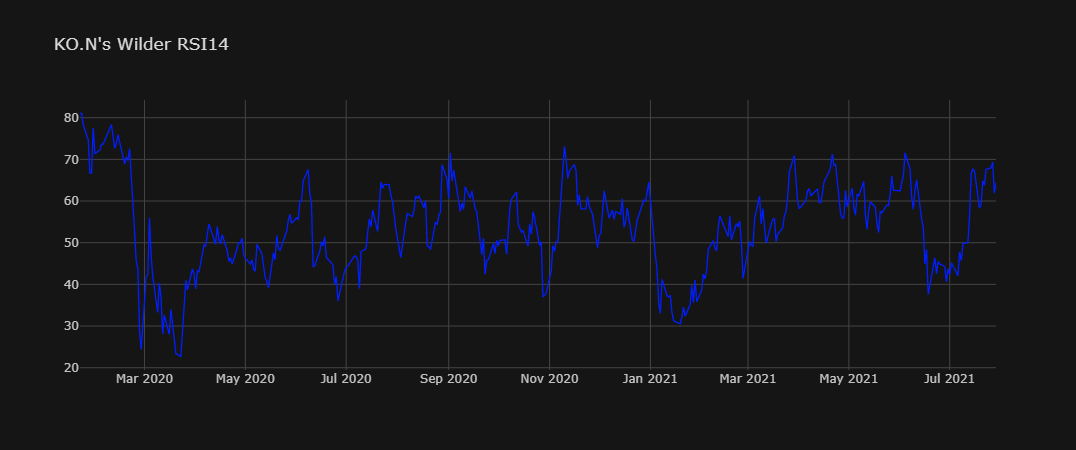

In [7]:
df2["KO.N's RSI14"].dropna().iplot(title="KO.N's Wilder RSI14",
                                   colors="#001EFF", theme="solar")

## Define a Python Function

In [8]:
def Refinitiv_RSI(start_date='2020-01-01', end_date='2021-08-01', bdpy=360,  # ' bdpy ' stands for 'business days per year'
                  maws=[10, 30, 60],  # ' maws ' stands for 'moving average windows'
                  rsiw=14, rsi_method="Wilder",  # "SMA", "EMA", "Wilder"
                  ric_list=['KO.N', 'VOD.L']):
    """Refinitiv_RSI(start_date='2020-01-01', end_date='2021-08-01', bdpy=360, maws=[10, 30, 60], rsiw=14, rsi_method="Wilder", ric_list=['KO.N', 'VOD.L']) Version 1.0
    This Python function returns the close prices of instruments asked for and
    calculates their (i) Natural Log Returns, (ii) 1st Difference,
    (iii) Moving Averages, (iv)Natural Log Returns' Moving Averages,
    (v) Annual Standard Deviations of a Rolling window of Natural Log Returns,
    and (vi) Relative Strength Indices

    Dependencies
    ----------

    Python library 'eikon' version 1.1.8
    Python library 'numpy' version 1.18.2
    Python library 'statistics'
    Python library 'pandas' version 1.2.4

    As well as the:

    Python library 'datetime' from 'datetime'. Imported via following line:
    >>> from datetime import datetime

    Python sub-library 'dateutil.relativedelta' version 2.8.1 from 'relativedelta'. Imported via following line:
    >>> from dateutil.relativedelta import relativedelta

    Parameters
    ----------

    start_date: str
        The starting date in the format '%Y-%m-%d'.
        Default: start_date='2020-01-01'.

    end_date: str
        The end date in the format '%Y-%m-%d'.
        Default: start_date='2021-08-01'.

    bdpy: int
        ' bdpy ' stands for 'business days per year'
        Default: bdpy=360.

    maws: list
        List of integers of the moving average windows asked for.
        Default: maws=[10, 30, 60].

    rsiw: int
        Relative Strength Index window
        Default: rsiw=14.

    rsi_method: str
        To choose from "SMA" for 'Simple Moving Average, "EMA" for 'Exponential Moving Average', or "Wilder".
        Default: rsi_method="Wilder".

    ric_list: list
        List of strings of RICs of instruments for which data is requested.
        Default: ric_list=['KO.N', 'VOD.L'].


    Returns
    -------

    Pandas data-frame
    """

    df1, err = ek.get_data(
        instruments=ric_list,
        fields=['TR.PriceClose.date', 'TR.PriceOpen', 'TR.PriceClose', 'TR.VOlume'],  # could also have TR.RSISimple30D & TR.RSISimple14D
        parameters={'SDate': start_date, 'EDate': end_date})

    # Step 1: Create a list of days ranging throughout our period.
    # The reason we look at every day is because some securities might trade on Sunday (e.g.: in middle-east)
    delta = datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')
    days = [datetime.strptime(start_date, '%Y-%m-%d') + relativedelta(days=i)
            for i in range(delta.days + 1)]

    # Step 2: Create a pandas data-frame to populate with a loop
    df2 = pandas.DataFrame(index=days)

    # Step 3: Create a loop to populate our 'df' dataframe
    # for m, i in enumerate(ric_list):
    for i in ric_list:

        # get Close Prices: (You may use any way to collect such data, here we are recycling previous data)
        _df = pandas.DataFrame(
            data=[float(j) for j in df1[df1["Instrument"] == i]["Price Close"]],
            columns=[f"{i} Close"],
            index=[datetime.strptime(df1[df1["Instrument"] == i]["Date"][j],
                                     '%Y-%m-%dT%H:%M:%SZ')
                   for j in list(df1[df1["Instrument"] == i]["Date"].index)])

        # get ln (logarithme naturel) return from Close Prices:
        _df[f"{i}'s ln Return"] = numpy.log(
            _df[f"{i} Close"] / _df[i + " Close"].shift(1))

        # get 1st difference in Close Prices:
        dCP = list((_df[f"{i} Close"] - _df[f"{i} Close"].shift(1)))
        # list.reverse(dCP)
        _df[f"{i}'s 1d Close"] = dCP

        for j in maws:
            # get Close Price's 10, 30 and 60 Day Moving Averages
            _df[f"{i}'s Close {str(j)}D MA"] = _df[f"{i} Close"].dropna().rolling(j).mean()

            # get Close Price's ln Return 10, 30 and 60 Day Moving Average
            _df[f"{i}'s ln Return' {str(j)}D MA"] = _df[f"{i}'s ln Return"].dropna().rolling(j).mean()
#             # You may also want to look into TA-lib's Simple Moving Average function:
#             _df[i + "'s ln Return' " + str(j) + " Day Moving Average"] = ta.SMA(_df[i + " Close"], j)

            # get Annualised Standard Deviation (i.e.: volatility) of the 10, 30 and 60 Day Rolling Window (Natural Log) Returns (based on CLOSE prices)
            _df[f"{i}'s Ann. S.D. of {str(j)}D Roll. of ln Returns"] = _df[f"{i}'s ln Return"].dropna().rolling(j).std()*(bdpy**0.5)


        # RSI: Simple Moving Average
        if rsi_method == "SMA" or rsi_method == "Cutler":
            RSIw = []
            for k in range(len(dCP) - rsiw):
                up_moves, down_moves = [], []
                for j in range(k, k + rsiw):
                    up_moves.append(max(dCP[j + 1], 0))  # ' + 1 ' because we're looking at 1st difference data, the 1st element of which is always nan.
                    down_moves.append(abs(min(dCP[j + 1], 0)))   # ' + 1 ' because we're looking at 1st difference data, the 1st element of which is always nan.
                AvgU = statistics.mean(up_moves)
                AvgD = statistics.mean(down_moves)
                if AvgD == 0:
                    RSIw.append(100)
                else:
                    RSw = AvgU/AvgD
                    RSIw.append(100-(100/(1+RSw)))
        # RSI: Exponential Moving Average
        if rsi_method == "EMA" or rsi_method == "MEMA" or rsi_method == "Wilder":
            if rsi_method == "MEMA" or rsi_method == "Wilder":
                a = 1 / rsiw
            elif rsi_method == "EMA":
                a = 2 / (rsiw + 1)
            RSIw, up_moves, down_moves = [], [], []
            for k in dCP[1:]:  # ' [1:] ' because we're looking at 1st difference data, the 1st element of which is always nan.
                up_moves.append(max(k, 0))
                down_moves.append(abs(min(k, 0)))
            AvgU = [statistics.mean(up_moves[0:rsiw])]
            AvgD = [statistics.mean(down_moves[0:rsiw])]
            if AvgD[0] == 0:
                RSIw.append(100)
            else:
                RSw = AvgU[0] / AvgD[0]
                RSIw.append(100 - (100 / (1 + RSw)))
            for k in range(rsiw, len(up_moves)):
                AvgU.append(a * up_moves[k] + (1 - a) * AvgU[k - rsiw])
                AvgD.append(a * down_moves[k] + (1 - a) * AvgD[k - rsiw])
                RSw = AvgU[k - rsiw] / AvgD[k - rsiw]
                RSIw.append(100 - (100 / (1 + RSw)))
        RSIw.append(numpy.nan)  # This is needed to inser the nan from the 1st difference that was already nan
        for k in range(len(_df.index) - len(RSIw)):
            RSIw.insert(0, numpy.nan)
        _df[f"{i}'s RSI{rsiw}"] = RSIw

        # Finally: merge all.
        return pandas.merge(df2, _df, how="outer", left_index=True, right_index=True)

In [9]:
df = Refinitiv_RSI(ric_list=['MSFT.O'])

In [12]:
df.dropna()

,MSFT.O Close,MSFT.O's ln Return,MSFT.O's 1d Close,MSFT.O's Close 10D MA,MSFT.O's ln Return' 10D MA,MSFT.O's Ann. S.D. of 10D Roll. of ln Returns,MSFT.O's Close 30D MA,MSFT.O's ln Return' 30D MA,MSFT.O's Ann. S.D. of 30D Roll. of ln Returns,MSFT.O's Close 60D MA,MSFT.O's ln Return' 60D MA,MSFT.O's Ann. S.D. of 60D Roll. of ln Returns,MSFT.O's RSI14
2020-03-30,160.23,0.067977,10.53,146.431,0.016823,0.996665,158.844000,-0.004855,1.170754,164.625167,-0.000041,0.847859,52.673834
2020-03-31,157.71,-0.015852,-2.52,147.545,0.007325,0.919086,157.860000,-0.005719,1.170091,164.610000,-0.000096,0.848196,51.337963
2020-04-01,152.11,-0.036154,-5.60,148.716,0.008011,0.904883,156.687667,-0.006933,1.174572,164.494667,-0.000741,0.852745,48.400379
2020-04-02,155.26,0.020497,3.15,149.971,0.008429,0.906763,155.715667,-0.005737,1.177938,164.456000,-0.000247,0.854052,50.129028
2020-04-03,153.83,-0.009253,-1.43,151.619,0.011332,0.862599,154.890333,-0.004975,1.174237,164.351667,-0.000665,0.853384,49.321227
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,289.67,0.012261,3.53,281.613,0.004134,0.178585,272.277500,0.003958,0.161648,260.488917,0.002153,0.206477,75.427556
2021-07-26,289.05,-0.002143,-0.62,282.786,0.004143,0.178457,273.316167,0.003802,0.162964,261.097917,0.002252,0.205188,73.900810
2021-07-27,286.54,-0.008722,-2.51,283.342,0.001959,0.182599,274.204500,0.003254,0.167933,261.670583,0.002129,0.206770,67.908078
2021-07-28,286.22,-0.001117,-0.32,283.713,0.001305,0.181845,275.133167,0.003414,0.165493,262.243250,0.002131,0.206756,67.160340


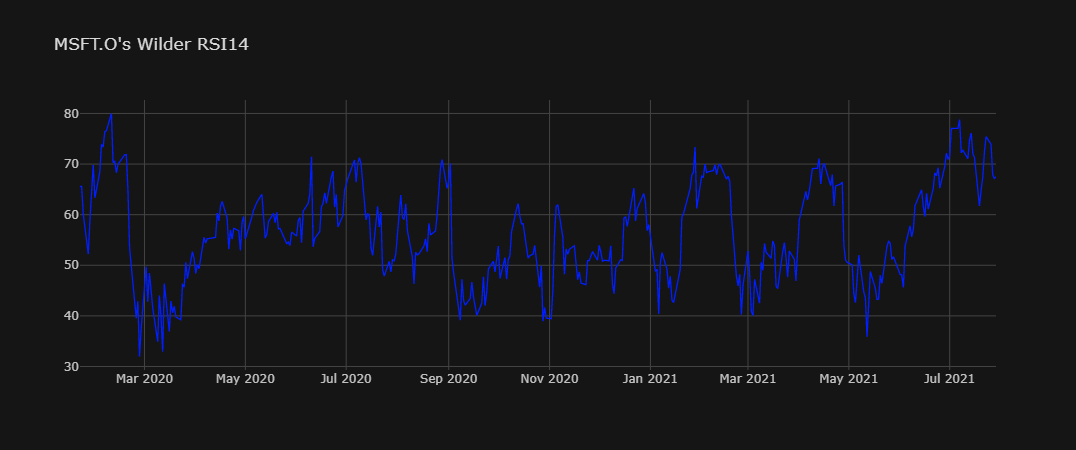

In [10]:
df["MSFT.O's RSI14"].dropna().iplot(title="MSFT.O's Wilder RSI14",
                                    colors="#001EFF", theme="solar")

## Apendix: Mathematical Finction for $RSI_{w, m, 1}$:

$$ \begin{array}{ll}
    RSI_{w, m, 1} &= 
        \begin{Bmatrix}
            100 & \text{if } \frac{\sum_{i=1}^w{|min(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)|}}{w} = 0 \\
            100 - \frac{100}{ 1 +\frac{
                \frac{
                    \sum_{i=1}^w{max(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)}
                    }{w}}
                {\frac{
                    \sum_{i=1}^w{|min(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)|}
                    }{w}}
            } & \text{otherwise}
        \end{Bmatrix} \\
    &= \begin{Bmatrix}
            100 & \text{if } \sum_{i=1}^w{|min(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)|} = 0 \\
            100 - \frac{100}{ 1 +\frac{
                \sum_{i=1}^w{max(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)}}
                {\sum_{i=1}^w{|min(P_{t-i+1} - P_{t-i} \text{ }, \text{ } 0)|}}
            } & \text{otherwise}
        \end{Bmatrix} \\
    \end{array}
$$

# References

- [How to install Ta-Lib in Python](https://blog.quantinsti.com/install-ta-lib-python/)